<a href="https://colab.research.google.com/github/ykitaguchi77/Kaggle/blob/main/Bunkruptcy-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Download Kaggle dataset**

## Google Driveのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備
Kaggleと同じコードで動くよう、フォルダの関係を調整

In [2]:
import os
import shutil

# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle



os.makedirs("./input/bankruptcy-risk-prediction", exist_ok=True)
os.makedirs("./output", exist_ok=True)

# zipファイルのダウンロード
!kaggle competitions download -c bankruptcy-risk-prediction -p /content
# 解凍
!unzip ./bankruptcy-risk-prediction.zip -d ./input/bankruptcy-risk-prediction

#Zipフォルダを削除
!rm ./bankruptcy-risk-prediction.zip

#作業フォルダを作成

os.makedirs("./Kaggle", exist_ok=True)
os.chdir("./Kaggle")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/22.3k [00:00<?, ?B/s]
100% 22.3k/22.3k [00:00<00:00, 19.5MB/s]
Archive:  ./bankruptcy-risk-prediction.zip
  inflating: ./input/bankruptcy-risk-prediction/submission_example.csv  
  inflating: ./input/bankruptcy-risk-prediction/test.csv  
  inflating: ./input/bankruptcy-risk-prediction/train.csv  


In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


#import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

!pip install optuna
import optuna
import optuna.integration.lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 209 kB 67.3 MB/s 
     |████████████████████████████████| 81 kB 7.8 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 147 kB 47.1 MB/s 
     |████████████████████████████████| 112 kB 47.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=9c23643a779c30a40c38d2d8f66d92e4094ba1a4a5ab28eab4e52abf18d73c16
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


#**Load data**

In [4]:
# load train.csv
train_df = pd.read_csv('../input/bankruptcy-risk-prediction/train.csv')

# load test.csv
test_df = pd.read_csv('../input/bankruptcy-risk-prediction/test.csv')

# load submission_example.csv
submission = pd.read_csv('../input/bankruptcy-risk-prediction/submission_example.csv')


print(f'train_df.shape = {train_df.shape}')
print(f'test_df.shape = {test_df.shape}')
print(f'submission.shape = {submission.shape}')

train_df

train_df.shape = (800, 22)
test_df.shape = (200, 21)
submission.shape = (200, 2)


,id,sum,term,payment,guarantees,reason,credits,other_credits,credit_report,marital_status,...,qualification,immigrant,residence_since,accommodation,estate,savings,dependents,phone,status,bankruptcy
0,0,1169,6,4,none,television or radio,2,none,critical account or other credits existing(not...,male single,...,skilled employee,yes,4,own,real estate,unknown or no savings account,1,yes,less-than 0 cu,0
1,1,5951,48,2,none,television or radio,1,none,existing credits paid back duly till now,female divorced or separated or married,...,skilled employee,yes,2,own,real estate,less-than 100 cu,1,none,0 to 200 cu,1
2,2,2096,12,2,none,education,1,none,critical account or other credits existing(not...,male single,...,unskilled resident,yes,3,own,real estate,less-than 100 cu,2,none,no checking account,0
3,3,7882,42,2,guarantor,furniture or equipment,1,none,existing credits paid back duly till now,male single,...,skilled employee,yes,4,for free,building society savings agreement or life ins...,less-than 100 cu,2,none,less-than 0 cu,0
4,4,4870,24,3,none,new car,2,none,delay in paying off in the past,male single,...,skilled employee,yes,4,for free,unknown or no property,less-than 100 cu,2,none,less-than 0 cu,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,795,2301,9,2,none,furniture or equipment,1,none,existing credits paid back duly till now,female divorced or separated or married,...,skilled employee,yes,4,rent,building society savings agreement or life ins...,100 to 500 cu,1,none,no checking account,0
796,796,7511,18,1,none,used car,1,none,existing credits paid back duly till now,male single,...,skilled employee,yes,4,for free,building society savings agreement or life ins...,unknown or no savings account,2,yes,less-than 0 cu,1
797,797,1258,12,2,none,furniture or equipment,2,none,critical account or other credits existing(not...,female divorced or separated or married,...,unskilled resident,yes,4,rent,building society savings agreement or life ins...,less-than 100 cu,1,none,no checking account,0
798,798,717,24,4,none,new car,2,none,delay in paying off in the past,male married or widowed,...,skilled employee,yes,4,own,car or other,unknown or no savings account,1,yes,no checking account,0


In [ ]:
# check data type(train_data)
print(train_df.dtypes)

# check missing values (train_data)
print(train_df.isnull().sum())

# check missing values (test_data)
print(test_df.isnull().sum())

In [6]:
# check train_data describe
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,800.0,399.50000,231.084400,0.0,199.75,399.5,599.25,799.0
sum,800.0,3190.97625,2732.671789,250.0,1342.25,2281.5,3914.25,15945.0
term,800.0,20.65125,12.156350,4.0,12.00,18.0,24.00,72.0
payment,800.0,2.96625,1.128806,1.0,2.00,3.0,4.00,4.0
credits,800.0,1.39625,0.569773,1.0,1.00,1.0,2.00,4.0
age,800.0,35.40625,11.470317,19.0,27.00,33.0,41.00,75.0
residence_since,800.0,2.84125,1.106833,1.0,2.00,3.0,4.00,4.0
dependents,800.0,1.14750,0.354825,1.0,1.00,1.0,1.00,2.0
bankruptcy,800.0,0.29875,0.457996,0.0,0.00,0.0,1.00,1.0


In [ ]:
sns.barplot(x="immigrant", y="bankruptcy", data=train_df, palette="Set3")

In [ ]:
sns.barplot(x="immigrant", y="bankruptcy", data=train_df, palette="Set3")

In [ ]:
sns.barplot(x="credits", y="bankruptcy", data=train_df, palette="Set3")

In [ ]:
fare = sns.FacetGrid(train_df, hue="bankruptcy",aspect=2)
fare.map(sns.kdeplot,'term',shade= True)
fare.set(xlim=(0, train_df["term"].max()))
fare.add_legend()

#**Data processing**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# obtain object data type as list (outcomeが数値でないラベルを抜き出す)
categories = train_df.columns[train_df.dtypes=='object'].values.tolist()

# One-hot Encoding
for cat in categories:
    
    # generate Label Encoder object
    train_df_encoder = pd.get_dummies(train_df[[cat]])
    test_df_encoder = pd.get_dummies(test_df[[cat]])

    #concat 
    train_df = pd.concat([train_df, train_df_encoder],axis=1)
    test_df = pd.concat([test_df, test_df_encoder], axis=1)
    
    #drop original (object data) categories
    train_df.drop(cat, axis=1, inplace=True)
    test_df.drop(cat, axis=1, inplace=True)

#drop duplicated columns
train_df.loc[:,~train_df.columns.duplicated()]
test_df.loc[:,~test_df.columns.duplicated()]

In [8]:
#Dataset

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()


In [81]:
from pandas._libs.tslibs.parsing import try_parse_date_and_time
# LightGBM / hyper parameters
lgbm_params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',                 # binary classification
    'metric': 'auc',                         # evaluator：AUC
    
    'learning_rate': 0.05, 
    
    'num_leaves': 32, 
    
    'n_estimators': 100000, 
    'importance_type': 'gain', 
    
    'random_state': 123, 
}

params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',
    'verbose': -1,
    "metric" : "None",
        'learning_rate': 0.05, 
    'num_leaves': 32, 
    'n_estimators': 100000, 
    'importance_type': 'gain',  
    'random_state': 123, 
}

#custom_metrics
import sklearn
from sklearn.metrics import f1_score
import numpy as np
from sklearn import datasets
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
def f1(preds, data):
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    metric = 2*precision*recall/(precision+recall)
    return 'f1', metric, True

def accuracy(preds, data):
    """精度 (Accuracy) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True


def precision(preds, data):
    """適合率 (Precision) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = precision_score(y_true, y_pred)
    return 'precision', metric, True


def recall(preds, data):
    """再現率 (Recall) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = recall_score(y_true, y_pred)
    return 'recall', metric, True

def prroc(preds, data):
    """AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    recall, precision, thresholds = precision_recall_curve(y_true, y_pred)
    metric = sklearn.metrics.auc(recall, precision)
    return 'prroc', metric, True

def aucroc(preds, data):
    """Precision_recall_AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    metric = roc_auc_score(y_true, y_pred)
    return 'aucroc', metric, True


def metrics(preds, data): #複数onにすると、複数の指標でearly stoppingをしてしまうので注意
    """複数の評価指標を計算するための関数"""
    # リストでまとめて返せば良い
    return [
        #accuracy(preds, data),
        #precision(preds, data),
        #recall(preds, data),
        #f1(preds, data),
        aucroc(preds, data),
        #prroc(preds, data), #これはうまくいかない
    ]

#**PythonAPI_lightGBM**

In [79]:
from sklearn.metrics import log_loss


# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv =y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    # データセットを生成する
    lgb_train = lgb.Dataset(x_train_cv, y_train_cv)
    lgb_eval = lgb.Dataset(x_valid_cv, y_valid_cv, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    evals_result = {}
    model = lgb.train(params, lgb_train, 
                  #valid_sets=lgb_eval,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=50,
                  # メトリックを追跡する対象のデータセット
                  valid_sets=[lgb_eval, lgb_train],
                  #valid_sets=[lgb_eval],
                  # 上記の名前
                  valid_names=['eval', 'train'],
                  # メトリックの履歴を残すオブジェクト
                  evals_result=evals_result,
                  # 独自メトリックを計算する関数
                  feval=metrics,
                 )
    
    
    # predict data for model fitting
    y_pred_train = model.predict(x_train_cv)
    
    # predict validation data
    y_pred_valid = model.predict(x_valid_cv)
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)

    #calculate log_loss
    logloss = log_loss(y_valid_cv, y_pred_valid)

    print(f'\nfold: {n_fold}')
    print(f'log loss: {logloss}')
    
    # AUC
    print(f'auc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid

# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')
    

Training until validation scores don't improve for 50 rounds.
[50]	train's aucroc: 0.978178	eval's aucroc: 0.724157
[100]	train's aucroc: 0.999209	eval's aucroc: 0.724722
Early stopping, best iteration is:
[75]	train's aucroc: 0.994443	eval's aucroc: 0.737714

fold: 0
log loss: 0.5508668898697192
auc(train_data) = 0.9944
auc(valid_data) = 0.7377


Training until validation scores don't improve for 50 rounds.
[50]	train's aucroc: 0.972598	eval's aucroc: 0.816592
[100]	train's aucroc: 0.999021	eval's aucroc: 0.835751
Early stopping, best iteration is:
[86]	train's aucroc: 0.997271	eval's aucroc: 0.8391

fold: 1
log loss: 0.446154058542619
auc(train_data) = 0.9973
auc(valid_data) = 0.8391


Training until validation scores don't improve for 50 rounds.
[50]	train's aucroc: 0.980235	eval's aucroc: 0.747024
[100]	train's aucroc: 0.99909	eval's aucroc: 0.75465
[150]	train's aucroc: 1	eval's aucroc: 0.755952
Early stopping, best iteration is:
[137]	train's aucroc: 1	eval's aucroc: 0.754464

fo

#**SKlearn_lightGBM**

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.978178	valid_1's auc: 0.724157
[100]	training's auc: 0.999209	valid_1's auc: 0.724722
[150]	training's auc: 1	valid_1's auc: 0.719827
Early stopping, best iteration is:
[75]	training's auc: 0.994443	valid_1's auc: 0.737714

auc(train_data) = 0.9944
auc(valid_data) = 0.7377

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.972598	valid_1's auc: 0.816592
[100]	training's auc: 0.999021	valid_1's auc: 0.835751
[150]	training's auc: 1	valid_1's auc: 0.831101
Early stopping, best iteration is:
[86]	training's auc: 0.997271	valid_1's auc: 0.8391

auc(train_data) = 0.9973
auc(valid_data) = 0.8391

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.980235	valid_1's auc: 0.747024
[100]	training's auc: 0.99909	valid_1's auc: 0.75465
[150]	training's auc: 1	valid_1's auc: 0.755952
[200]	training's auc: 1	valid_1's auc: 0.75372
Early stopping,

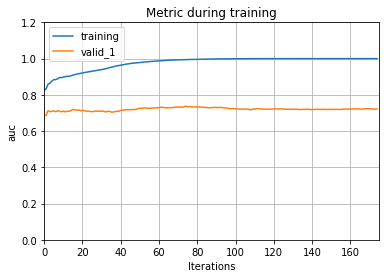

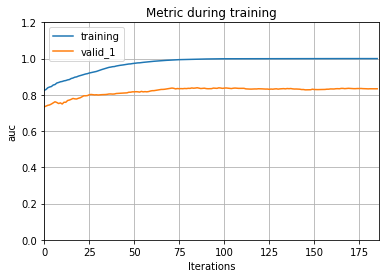

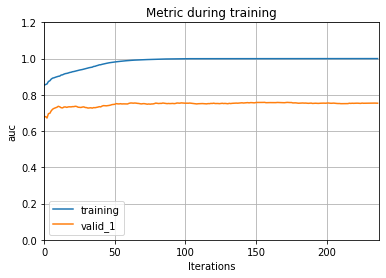

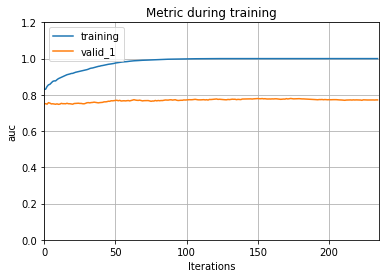

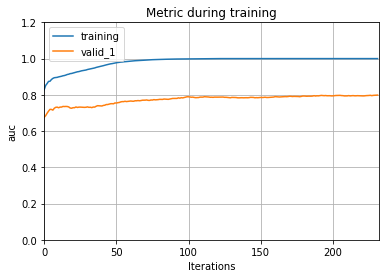

In [82]:
# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv = y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    
    
    # generate LightGBM model object
    model = lgb.LGBMClassifier(**lgbm_params)
    
    
    # model fitting
    model.fit(
        x_train_cv, 
        y_train_cv, 
        eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
        early_stopping_rounds = 100, 
        categorical_feature = category_list,
        verbose = 50, 
    )
    
    
    # predict data for model fitting
    y_pred_train = model.predict_proba(x_train_cv, num_iteration=model.best_iteration_)[:, 1]
    
    # predict validation data
    y_pred_valid = model.predict_proba(x_valid_cv, num_iteration=model.best_iteration_)[:, 1]
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)
    
    # AUC
    print(f'\nauc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid
    
    
    # plot of model fitting curve
    lgb.plot_metric(model, ylim=(0, 1.2));

In [38]:
# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')

auc(train_data)_mean = 0.9983
auc(valid_data)_mean = 0.7833


In [22]:
# Prediction of test data

# list of prediction based on each CV
preds_test = []


# predictor features of test data
x_test = test_df.drop(['id'], axis=1)


# predict with learned model based on CV
for model in models:
    
    # predict
    pred = model.predict_proba(x_test, num_iteration=model.best_iteration_)[:, 1]
    
    # append
    preds_test.append(pred)

In [ ]:
# preds_test into NumPy type
preds_test_np = np.array(preds_test)

# obtain its mean
preds_test_np_mean = preds_test_np.mean(axis=0)

# print
preds_test_np_mean

In [ ]:
# obtain submission file from the prediction
submission['proba'] = preds_test_np_mean

submission

In [24]:
# save submission
submission.to_csv('./submission.csv', index=False)